<div dir='rtl'>
<h1>پروژه سوم علوم اعصاب محاسباتی</h1>
<br/>
    - صورت پروژه در 
    <a href="https://cnrl.github.io/cns-project-template/Phase3.html">این آدرس</a>
    قابل مشاهده است.
<br/>
    - <font color='red'>با توجه به دشواری حفظ ساختار صورت پروژه در گزارش، آن ساختار نادیده گرفته شده و
    مطالب با ساختاری مناسب برای دنبال کردن نمودار‌ها و مطالب منظم شده‌اند؛ با اینحال تمام مطالب خواسته شده
    در صورت پروژه، در این گزارش پوشانده شده‌اند.</font>
<br/>
    - در فاز‌های قبل به بررسی پارامتر‌های نورون‌ها و جوامع پرداختیم. بنابراین در این فاز این پارامتر‌ها را مورد بررسی قرار نخواهیم داد و بر روی پارامتر‌های اتصالات و همچنین تفاوت جمعیت‌ها تمرکز خواهیم کرد.
<br/>
    - در این فاز توانایی پنهان کردن کد‌ها در ژوپیتر نوت‌بوک را پیدا نکردیم. این اصلاح در فاز‌های بعدی انجام خواهد شد.
<br/>
    - توضیحات نمودار‌ها زیر آن‌ها آورده شده است.
</div>

<div dir='rtl'>
<h2>0. فهرست مطالب</h2>
<ol>
    <li><a href="#1">انواع جریان ورودی</a></li>
    <li><a href="#2">تغییر تصمیم بر مبنای تغییر ورودی</a></li>
    <li><a href="#3">وزن اتصالات داخلی یک جمعیت تحریکی</a></li>
    <li><a href="#4">تعداد اتصالات داخلی یک جمعیت تحریکی</a></li>
    <li><a href="#5">وزن اتصالات از یک جمعیت تحریکی به جمعیت بازدارنده</a></li>
    <li><a href="#6">وزن اتصالات از جمعیت بازدارنده به یک جمعیت تحریکی</a></li>
    <li><a href="#7">اندازه یک جمعیت تحریکی</a></li>
    <li><a href="#8">ثابت زمانی ($tau$) یک جمعیت تجریکی</a></li>
    <li><a href="#9">اندازه جمعیت بازدارنده</a></li>
    <li><a href="#10">ثابت زمانی ($tau$) جمعیت بازدارنده</a></li>
    <li><a href="#11">شبکه «کاملا» متقارن</a></li>
</ol>
</div>

In [1]:
from cnsproject.network.neural_populations import LIFPopulation
from cnsproject.network.connections import SimpleConnection
from cnsproject.network.connectivity_patterns import *
from cnsproject.network.monitors import Monitor
from cnsproject.plotting.plotting import Plotter
from cnsproject.utils import *
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore")

<div dir='rtl'>
<br/>
بجز ابزار شبیه‌سازی (که import شده‌اند)، توابع پایین در این تمرین خاص، برای شبیه‌سازی و مقایسه نورون‌ها در کنار هم به ما کمک خواهد کرد. همچنین در این تمرین، هر شبیه‌سازی را به مدت 250ms ادامه خواهیم داد.
</div>

In [2]:
time=250 #ms


def dm_simulate(p, items, I1, I2, time=time, postfix='', dt=1., name='', cd=True, **args):
    """
    items: a dictionary containig: Ex1, Ex2, In, conn_Ex1, conn_Ex2,
                conn_Ex1_In, conn_Ex2_In, conn_In_Ex1, conn_In_Ex2
    """
    monitor1 = Monitor(items['Ex1'], state_variables=["s"], time=time)
    monitor2 = Monitor(items['Ex2'], state_variables=["s"], time=time)
    monitor3 = Monitor(items['In'], state_variables=["s"], time=time)
    for cls in items.values():
        cls.reset()
    def func(I1, I2):
        items['Ex1'].forward(I1+items['conn_Ex1'].I+items['conn_In_Ex1'].I)
        items['Ex2'].forward(I2+items['conn_Ex2'].I+items['conn_In_Ex2'].I)
        items['In'].forward(items['conn_Ex1_In'].I+items['conn_Ex2_In'].I)
        items['conn_Ex1'].forward(items['Ex1'].s)
        items['conn_Ex2'].forward(items['Ex2'].s)
        items['conn_Ex1_In'].forward(items['Ex1'].s)
        items['conn_Ex2_In'].forward(items['Ex2'].s)
        items['conn_In_Ex1'].forward(items['In'].s)
        items['conn_In_Ex2'].forward(items['In'].s)
    monitor1.simulate(func, {'I1': I1, 'I2': I2}, attendance=[monitor2,monitor3])
    data_Ex1 = p.population_activity_raster('s'+postfix, monitor=monitor1, x_vis=False, y_label='spikes',
                                    title=name, label_prefix='EX1-')
    data_Ex2 = p.population_activity_raster('s'+postfix, monitor=monitor2, additive=True, label_prefix='EX2-',
                                    color='b', start=items['Ex1'].s.numel()+items['In'].s.numel())
    data_In = p.population_activity_raster('s'+postfix, monitor=monitor3, additive=True, label_prefix='In-',
                                   start=items['Ex1'].s.numel(), marker='x')
    p.population_activity('a'+postfix, raster_data=data_Ex1, x_vis=False,
                          y_label="activity", label='EX1', color='g')
    p.population_activity('a'+postfix, raster_data=data_Ex2, label='EX2', additive=True)
    p.population_activity('a'+postfix, raster_data=data_In, label='In', color='r', additive=True)
    p['a'+postfix].legend()
    if cd:
        p.current_dynamic('i'+postfix, I=I1, y_label="I (mA)", repeat_till=time, label="Ex1 input", color='g',
                          population_alpha=0.025)
        p.current_dynamic('i'+postfix, I=I2, y_label="I (mA)", repeat_till=time, label="Ex2 input", color='b',
                          additive=True, population_alpha=0.025)
        

dt = 1
Ex1 = LIFPopulation((50,), is_excitatory=True, dt=dt)
Ex2 = LIFPopulation((50,), is_excitatory=True, dt=dt)
In = LIFPopulation((20,), is_excitatory=False, dt=dt)
def default_conn(Ex1,Ex2,In):
    conn_Ex1 = SimpleConnection(pre=Ex1, post=Ex1, dt=dt,
                             w=norm_weights,
                             connectivity=internal_rfnopp_connectivity,
                             wmean=50.,
                             wstd=5.,
                             connections_rate=.1)
    conn_Ex2 = SimpleConnection(pre=Ex2, post=Ex2, dt=dt,
                             w=norm_weights,
                             connectivity=internal_rfnopp_connectivity,
                             wmean=50.,
                             wstd=5.,
                             connections_rate=.1)
    conn_Ex1_In = SimpleConnection(pre=Ex1, post=In, dt=dt,
                             w=norm_weights,
                             connectivity=rfnopp_connectivity,
                             wmean=50.,
                             wstd=5.,
                             connections_rate=.1)
    conn_Ex2_In = SimpleConnection(pre=Ex2, post=In, dt=dt,
                             w=norm_weights,
                             connectivity=rfnopp_connectivity,
                             wmean=50.,
                             wstd=5.,
                             connections_rate=.1)
    conn_In_Ex1 = SimpleConnection(pre=In, post=Ex1, dt=dt,
                             w=norm_weights,
                             connectivity=rfnopp_connectivity,
                             wmean=50.,
                             wstd=5.,
                             connections_rate=.1)
    conn_In_Ex2 = SimpleConnection(pre=In, post=Ex2, dt=dt,
                             w=norm_weights,
                             connectivity=rfnopp_connectivity,
                             wmean=50.,
                             wstd=5.,
                             connections_rate=.1)
    return conn_Ex1,conn_Ex2,conn_Ex1_In,conn_Ex2_In,conn_In_Ex1,conn_In_Ex2

conn_Ex1,conn_Ex2,conn_Ex1_In,conn_Ex2_In,conn_In_Ex1,conn_In_Ex2 = default_conn(Ex1,Ex2,In)

<a id='1'></a>
<div dir='rtl'>
<h2>1. انواع جریان ورودی</h2>
</div>

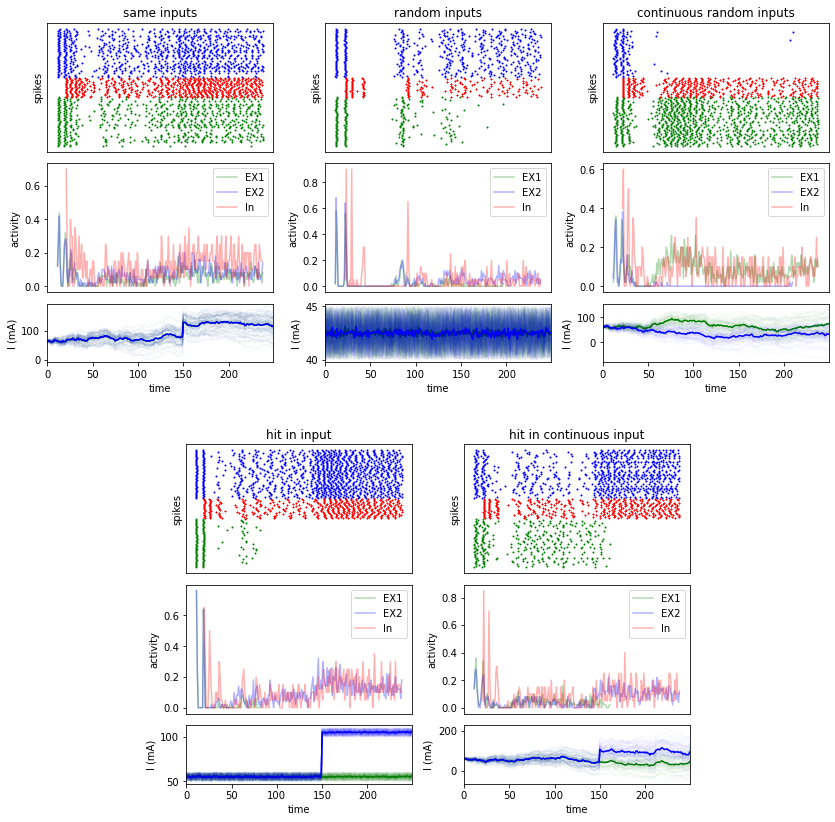

In [5]:
plt.figure(figsize=(14,14))
p = Plotter([
    ['s1','s1','s2','s2','s3','s3'],
    ['s1','s1','s2','s2','s3','s3'],
    ['a1','a1','a2','a2','a3','a3'],
    ['a1','a1','a2','a2','a3','a3'],
    ['i1','i1','i2','i2','i3','i3'],
    [None,None,None,None,None,None],
    [None,'s4','s4','s5','s5',None],
    [None,'s4','s4','s5','s5',None],
    [None,'a4','a4','a5','a5',None],
    [None,'a4','a4','a5','a5',None],
    [None,'i4','i4','i5','i5',None],
], wspace=0.6)

simulate = lambda I1,I2,postfix,name: dm_simulate(p, {
        'Ex1':Ex1,
        'Ex2':Ex2,
        'In':In,
        'conn_Ex1': conn_Ex1,
        'conn_Ex2': conn_Ex2,
        'conn_Ex1_In': conn_Ex1_In,
        'conn_Ex2_In': conn_Ex2_In,
        'conn_In_Ex1': conn_In_Ex1,
        'conn_In_Ex2': conn_In_Ex2,
    }, I1, I2, postfix=postfix, name=name)


I1 = generate_function(time, shape=(50,),
           shift={0: 65, 150: 50},
           noise=1,
           population_noise=1)
simulate(I1,I1,'1','same inputs')


I1 = torch.rand(time,50)*5+40
I2 = torch.rand(time,50)*5+40
simulate(I1,I2,'2','random inputs')


I1 = generate_function(time, shape=(50,),
           shift={0: 65},
           noise=1,
           population_noise=1)
I2 = generate_function(time, shape=(50,),
           shift={0: 65},
           noise=1,
           population_noise=1)
simulate(I1,I2,'3','continuous random inputs')


I1 = torch.rand(time,50)*10+50
I2 = I1.clone()
I2[-100:] += 50
simulate(I1,I2,'4','hit in input')


I1 = generate_function(time, shape=(50,),
           shift={0: 65},
           noise=1,
           population_noise=1)
I2 = I1.clone()
I2[-100:] += generate_function(100, shape=(50,),
           shift={0: 65},
           noise=1,
           population_noise=1)
simulate(I1,I2,'5','hit in continuous input')


p.show()

<div dir='rtl'>
<br/>
- دیده می‌شود که در حالت اول که ورودی جریان یکسانی به دو جمعیت داده شده است، دو جمعیت به صورت پایاپایی پیشروی می‌کنند. با اینحال، می‌بینیم که جمعیت آبی رو به پیروزیست. دلیل این امر مطابقت اتفاقی اتصالات این شبکه با ورودی نامتقارن شبکه است (ورودی نورون‌ها نویز دارد).
<br/>
- در نمودار دوم، نتیجه‌ی قبل را این بار با نوع متفاوتی از جریان تصادفی شاهد هستیم.
<br/>
- در نمودار سوم مشاهده می‌کنیم که زمانی که ورودی به صورت ناعادلانه‌ای به نفع جمعیت سبز نامتقارن می‌شود، این جمعیت به سادگی رقابت را برنده می‌شود. به این امر دقت کنید که جمعیت سبز با فعال کردن جمعیت قرمز، باعث پیشگیری از فعال شدن جمعیت آبی می‌شود.
<br/>
- در نمودار چهارم می‌بینیم که دوباره، جمعیت سبز مانند آنچه در نمودار دوم اتفاق افتاد، درحال رشد و پیروزیست تا اینکه ورودی به صورت ضربه‌ای، به سمت جمعیت آبی نامتقارن می‌شود و به این شکل، جمعیت آبی به سرعت و سادگی، دارای فعالیتی زیاد شده و با فعال کردن جمعیت قرمز، فعالیت جمعیت سبز را از بین می‌برد. توجه کنید که قطع فعالیت جمعیت سبز مقداری پس از آغاز فعالیت جمعیت آبی رخ می‌دهد و به این دلیل است که چند لحظه‌ای طول می‌کشد تا جمعیت قرمز فعال شده و جلوی فعالیت جمعیت سبز را بگیرد.
<br/>
- در نمودار پنجم، نتیجه‌ای مشابه نمودار چهارم را این بار با نوع متفاوتی از ورودی تصادفی شاهد هستیم.
</div>

<a id='2'></a>
<div dir='rtl'>
    <h2>2. تغییر تصمیم بر مبنای تغییر ورودی</h2>
</div>

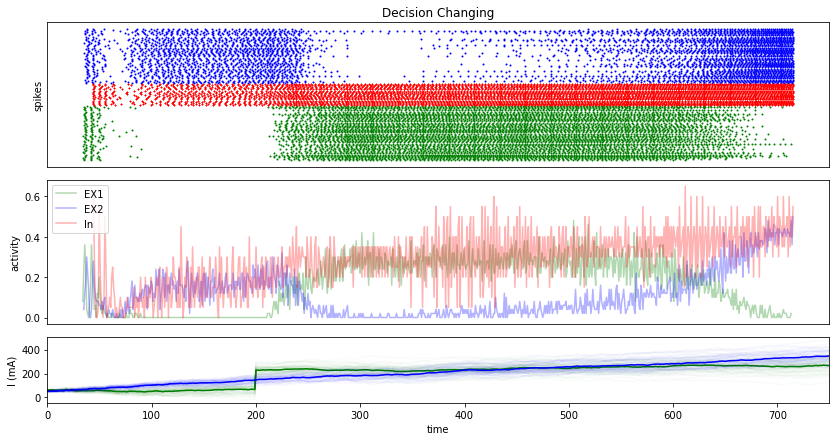

In [12]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s'],
    ['s'],
    ['a'],
    ['a'],
    ['i'],
], wspace=0.3)

I1 = generate_function(time*3, shape=(50,),
           shift={0: 60, 200: 160},
           noise=.5,
           population_noise=1)
I2 = generate_function(time*3, shape=(50,),
           shift={0: 50},
           slope=.2,
           noise=.5,
           population_noise=1)
dm_simulate(p, {
    'Ex1':Ex1,
    'Ex2':Ex2,
    'In':In,
    'conn_Ex1': conn_Ex1,
    'conn_Ex2': conn_Ex2,
    'conn_Ex1_In': conn_Ex1_In,
    'conn_Ex2_In': conn_Ex2_In,
    'conn_In_Ex1': conn_In_Ex1,
    'conn_In_Ex2': conn_In_Ex2,
}, I1, I2, name='Decision Changing', time=time*3)

<div dir='rtl'>
<br/>
نمودار بالا خود گویای اتفاقی که در حال رخ دادن است می‌باشد. در ابتدا شبکه با رشد ورودی آبی، به سمت جمعیت آبی متمایل می‌شود تا اینکه ورودی جمعیت سبز به یکباره رشد کرده و این امر باعث تغییر تصمیم شبکه از آبی به سبز می‌شود. سپس دوباره با رشد ورودی آبی، تصمیم به جمعیت آبی منعطف می‌شود.
</div>

<a id='3'></a>
<div dir='rtl'>
    <h2>3. وزن اتصالات داخلی یک جمعیت تحریکی</h2>
</div>

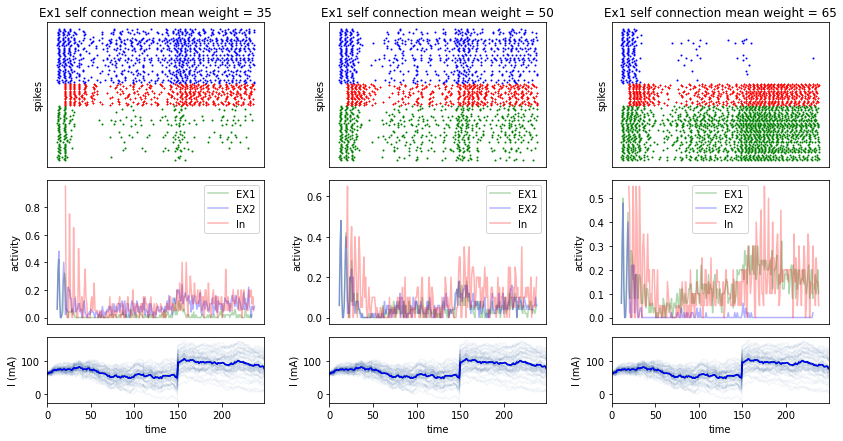

In [15]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)

I1 = generate_function(time, shape=(50,),
           shift={0: 65, 150: 50},
           noise=1,
           population_noise=1)

simulate = lambda conn,postfix,name: dm_simulate(p, {
    'Ex1':Ex1,
    'Ex2':Ex2,
    'In':In,
    'conn_Ex1': conn,
    'conn_Ex2': conn_Ex2,
    'conn_Ex1_In': conn_Ex1_In,
    'conn_Ex2_In': conn_Ex2_In,
    'conn_In_Ex1': conn_In_Ex1,
    'conn_In_Ex2': conn_In_Ex2,
}, I1, I1, postfix=postfix, name=name)



conn = SimpleConnection(pre=Ex1, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=internal_rfnopp_connectivity,
                         wmean=35.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '1', 'Ex1 self connection mean weight = 35')



conn = SimpleConnection(pre=Ex1, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=internal_rfnopp_connectivity,
                         wmean=50.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '2', 'Ex1 self connection mean weight = 50')



conn = SimpleConnection(pre=Ex1, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=internal_rfnopp_connectivity,
                         wmean=65.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '3', 'Ex1 self connection mean weight = 65')

p.show()

<div dir='rtl'>
<br/>
در نمودار وسط که وزن اتصالات داخلی دو جمعیت آبی و سبز برابر است، مشاهده می‌کنیم که فعالیت مشابهی دارند.
    اما به سادگی می‌توان دید که فعالیت نسبی جمعیت سبز‌رنگ رابطه‌ی مستقیم با شدت وزن‌های داخلی‌اش دارد. بنابراین با زیاد شدن وزن اتصالات داخلی یک جمعیت نسبت به جمعیت دوم، فعالیت جمعیت زیاد شده و جمعیت رو به پیروزی می‌رود.
</div>

<a id='4'></a>
<div dir='rtl'>
    <h2>4. تعداد اتصالات داخلی یک جمعیت تحریکی</h2>
</div>

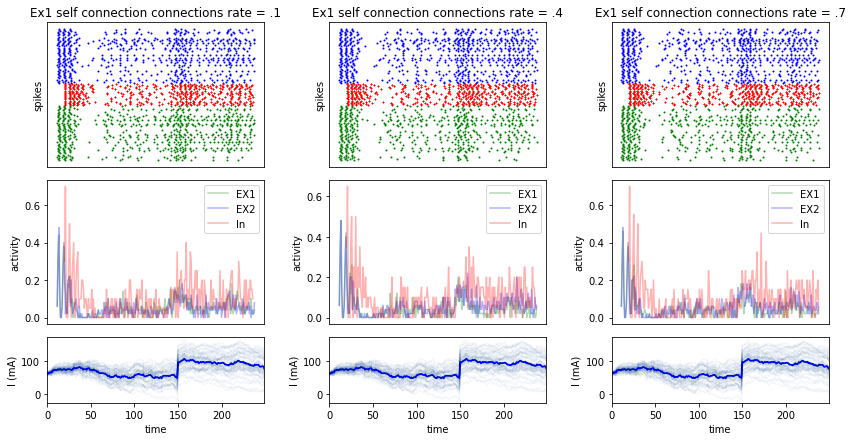

In [16]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)

conn = SimpleConnection(pre=Ex1, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=internal_rfnopp_connectivity,
                         wmean=50.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '1', 'Ex1 self connection connections rate = .1')



conn = SimpleConnection(pre=Ex1, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=internal_rfnopp_connectivity,
                         wmean=50.,
                         wstd=5.,
                         connections_rate=.4)
simulate(conn, '2', 'Ex1 self connection connections rate = .4')



conn = SimpleConnection(pre=Ex1, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=internal_rfnopp_connectivity,
                         wmean=50.,
                         wstd=5.,
                         connections_rate=.7)
simulate(conn, '3', 'Ex1 self connection connections rate = .7')

p.show()

<div dir='rtl'>
<br/>
مشاهده می‌کنیم که تغییر در تعداد اتصالات داخلی یک جمعیت تحریکی هیچ تأثیری در تصمیم‌گیری ایجاد نمی‌کند. دلیل آن است که وزن‌های اتصالات داخلی با توجه به تعداد این اتصالات نرمال می‌شوند و به این ترتیب، کلیت تأثیرپذیری جمعیت از خودش یکسان باقی می‌ماند.
</div>

<a id='5'></a>
<div dir='rtl'>
    <h2>5. وزن اتصالات از یک جمعیت تحریکی به جمعیت بازدارنده</h2>
</div>

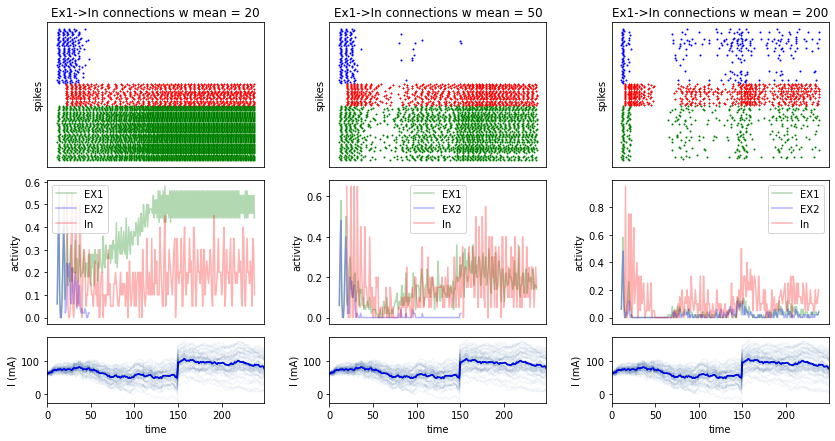

In [17]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)

conn_Ex1_65 = SimpleConnection(pre=Ex1, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=internal_rfnopp_connectivity,
                         wmean=65.,
                         wstd=5.,
                         connections_rate=.1)
simulate = lambda conn,postfix,name: dm_simulate(p, {
    'Ex1':Ex1,
    'Ex2':Ex2,
    'In':In,
    'conn_Ex1': conn_Ex1_65,
    'conn_Ex2': conn_Ex2,
    'conn_Ex1_In': conn,
    'conn_Ex2_In': conn_Ex2_In,
    'conn_In_Ex1': conn_In_Ex1,
    'conn_In_Ex2': conn_In_Ex2,
}, I1, I1, postfix=postfix, name=name)



conn = SimpleConnection(pre=Ex1, post=In, dt=dt,
                         w=norm_weights,
                         connectivity=rfnopp_connectivity,
                         wmean=20.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '1', 'Ex1->In connections w mean = 20')



conn = SimpleConnection(pre=Ex1, post=In, dt=dt,
                         w=norm_weights,
                         connectivity=rfnopp_connectivity,
                         wmean=50.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '2', 'Ex1->In connections w mean = 50')



conn = SimpleConnection(pre=Ex1, post=In, dt=dt,
                         w=norm_weights,
                         connectivity=rfnopp_connectivity,
                         wmean=200.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '3', 'Ex1->In connections w mean = 200')

p.show()

<div dir='rtl'>
<br/>
شایان ذکر است که در نمودار‌های بالا، اتصال‌های داخلی جمعیت سبز سنگین‌تر بوده و به صورت پیشفرض، جمعیت سبز‌رنگ برنده رقابت است. اما مشاهده می‌شود که با افزایش وزن اتصالات این جمعیت به جمعیت بازدارنده، این پیروزی رو به شکست می‌رود. دلیل آن است که با افزایش این وزن‌ها، تأثیر اسپایک‌های این جمعیت بر روی جمعیت بازدارنده زیاد‌تر شده و بدین‌ترتیب، جمعیت بازدارند مانع از ماندگاری این موفقیت می‌شود و به دلیل انطباق این تأثیر با فعالیت جمعیت سبز، این جمعیت بیشتر از جمعیت آبی متضرر می‌شود.
</div>

<a id='6'></a>
<div dir='rtl'>
<h2>6. وزن اتصالات از جمعیت بازدارنده به یک جمعیت تحریکی</h2>
</div>

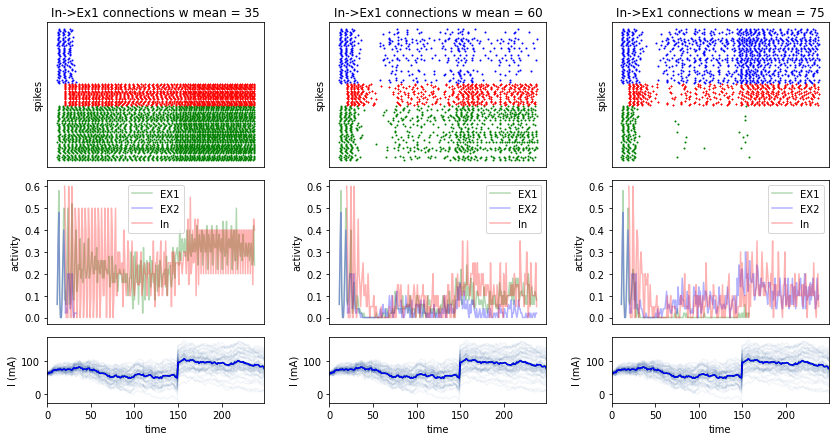

In [18]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)


simulate = lambda conn,postfix,name: dm_simulate(p, {
    'Ex1':Ex1,
    'Ex2':Ex2,
    'In':In,
    'conn_Ex1': conn_Ex1_65,
    'conn_Ex2': conn_Ex2,
    'conn_Ex1_In': conn_Ex1_In,
    'conn_Ex2_In': conn_Ex2_In,
    'conn_In_Ex1': conn,
    'conn_In_Ex2': conn_In_Ex2,
}, I1, I1, postfix=postfix, name=name)



conn = SimpleConnection(pre=In, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=rfnopp_connectivity,
                         wmean=35.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '1', 'In->Ex1 connections w mean = 35')



conn = SimpleConnection(pre=In, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=rfnopp_connectivity,
                         wmean=60.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '2', 'In->Ex1 connections w mean = 60')



conn = SimpleConnection(pre=In, post=Ex1, dt=dt,
                         w=norm_weights,
                         connectivity=rfnopp_connectivity,
                         wmean=75.,
                         wstd=5.,
                         connections_rate=.1)
simulate(conn, '3', 'In->Ex1 connections w mean = 75')

p.show()

<div dir='rtl'>
<br/>
شایان ذکر است که در نمودار‌های بالا، اتصال‌های داخلی جمعیت سبز سنگین‌تر بوده و به صورت پیشفرض، جمعیت سبز‌رنگ برنده رقابت است. اما مشاهده می‌شود که با افزایش وزن اتصالات این جمعیت به جمعیت بازدارنده، این پیروزی رو به شکست می‌رود. دلیل بسیار واضح است. با افزایش قدرت اتصال جمعیت بازدارنده به یک جمعیت، به معنای سرکوب آن جمعیت است.
</div>

<a id='7'></a>
<div dir='rtl'>
<h2>7. اندازه یک جمعیت تحریکی</h2>
</div>

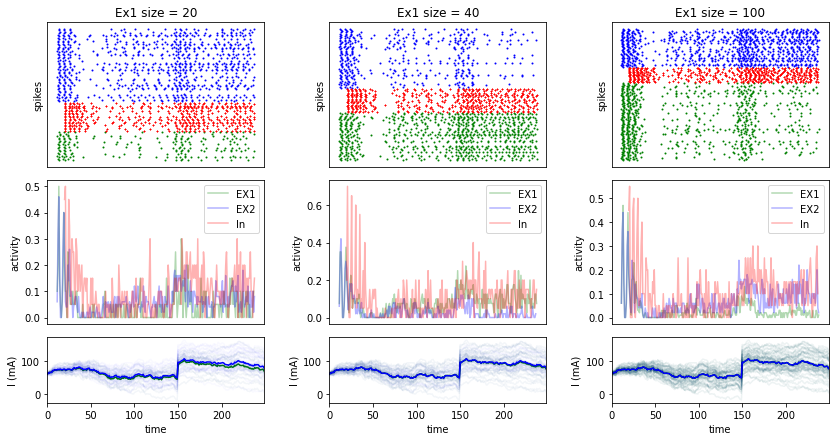

In [19]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)

def simulate(pop,postfix,name):
    conn_Ex1,conn_Ex2,conn_Ex1_In,conn_Ex2_In,conn_In_Ex1,conn_In_Ex2 = default_conn(pop,Ex2,In)
    I = I1.T
    while pop.shape[0]>I.shape[0]:
        I = torch.tensor(I.tolist()+I.tolist())
    I = I[:pop.shape[0]].T
    return dm_simulate(p, {
        'Ex1':pop,
        'Ex2':Ex2,
        'In':In,
        'conn_Ex1': conn_Ex1,
        'conn_Ex2': conn_Ex2,
        'conn_Ex1_In': conn_Ex1_In,
        'conn_Ex2_In': conn_Ex2_In,
        'conn_In_Ex1': conn_In_Ex1,
        'conn_In_Ex2': conn_In_Ex2,
    }, I, I1, postfix=postfix, name=name)



new_Ex1 = LIFPopulation((20,), is_excitatory=True, dt=dt)
simulate(new_Ex1, '1', 'Ex1 size = 20')

new_Ex1 = LIFPopulation((40,), is_excitatory=True, dt=dt)
simulate(new_Ex1, '2', 'Ex1 size = 40')

new_Ex1 = LIFPopulation((100,), is_excitatory=True, dt=dt)
simulate(new_Ex1, '3', 'Ex1 size = 100')

p.show()

<div dir='rtl'>
<br/>
درنمودار‌های spikes بالا توجه کنید که دچار خطا نشوید چون به دلیل تعداد متفاوت نورون‌ها، اسکیل محور عمودی نمودار‌ها متفاوت است و باعث خطای دید می‌شود. به صورت کلی، با توجه به نمودار activity می‌بینیم که این عامل تأثیر زیادی بر روی تصمیم‌گیری ندارد. دلیل آن است که وزن‌های شبکه نسبت به این تعداد نرمال شده و تأثیر آن را از بین می‌برند.
<br/>
با اینحال تصور می‌شود که زیاد شدن تعداد این نورون‌ها، سرعت پیشروی را زمانی که مدل رو به پیروزی باشد بیشتر کند.
    دلیل این حدس آن است که تعداد بیشتر نورون ثبات بیشتری دارد و در برابر تأثیر منفی جمعیت بازدارنده مقاومت بیشتری نشان می‌دهد. این امر را بررسی می‌کنیم:
</div>

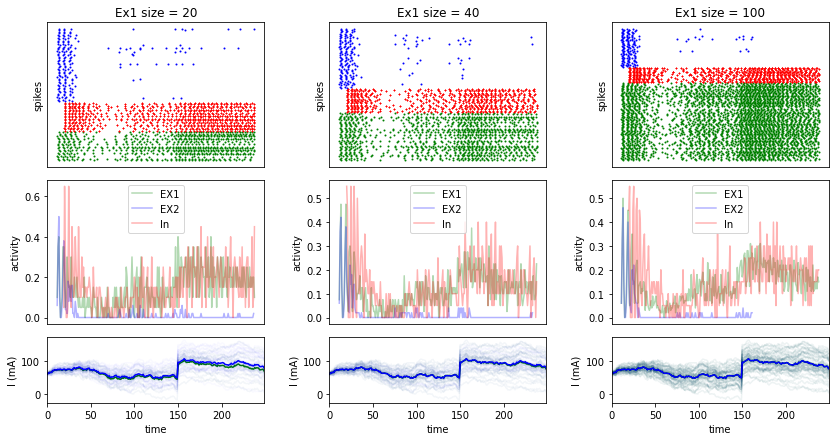

In [21]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)

def simulate_65(pop,postfix,name):
    conn_Ex1,conn_Ex2,conn_Ex1_In,conn_Ex2_In,conn_In_Ex1,conn_In_Ex2 = default_conn(pop,Ex2,In)
    conn_Ex1_65 = SimpleConnection(pre=pop, post=pop, dt=dt,
                         w=norm_weights,
                         connectivity=internal_rfnopp_connectivity,
                         wmean=65.,
                         wstd=5.,
                         connections_rate=.1)
    I = I1.T
    while pop.shape[0]>I.shape[0]:
        I = torch.tensor(I.tolist()+I.tolist())
    I = I[:pop.shape[0]].T
    return dm_simulate(p, {
        'Ex1':pop,
        'Ex2':Ex2,
        'In':In,
        'conn_Ex1': conn_Ex1_65,
        'conn_Ex2': conn_Ex2,
        'conn_Ex1_In': conn_Ex1_In,
        'conn_Ex2_In': conn_Ex2_In,
        'conn_In_Ex1': conn_In_Ex1,
        'conn_In_Ex2': conn_In_Ex2,
    }, I, I1, postfix=postfix, name=name)


new_Ex1 = LIFPopulation((20,), is_excitatory=True, dt=dt)
simulate_65(new_Ex1, '1', 'Ex1 size = 20')


new_Ex1 = LIFPopulation((40,), is_excitatory=True, dt=dt)
simulate_65(new_Ex1, '2', 'Ex1 size = 40')


new_Ex1 = LIFPopulation((100,), is_excitatory=True, dt=dt)
simulate_65(new_Ex1, '3', 'Ex1 size = 100')

p.show()

<div dir='rtl'>
<br/>
مشاهده می‌کنیم که حدسی که زده بودیم اشتباه بود و این عامل حتی در زمانی که دو جمعیت در حالت ناعادلانه‌ای هستند، باز هم بی‌تأثیر است. دلیل همان چیزی است که بالاتر نیز ذکر شد. همه تأثیرات ورودی توسط وزن‌ها اسکیل و نرمال می‌شوند و تعداد را بی‌تأثیر می‌کنند.
</div>

<a id='8'></a>
<div dir='rtl'>
<h2>8. ثابت زمانی ( $tau$ ) یک جمعیت تجریکی</h2>
</div>

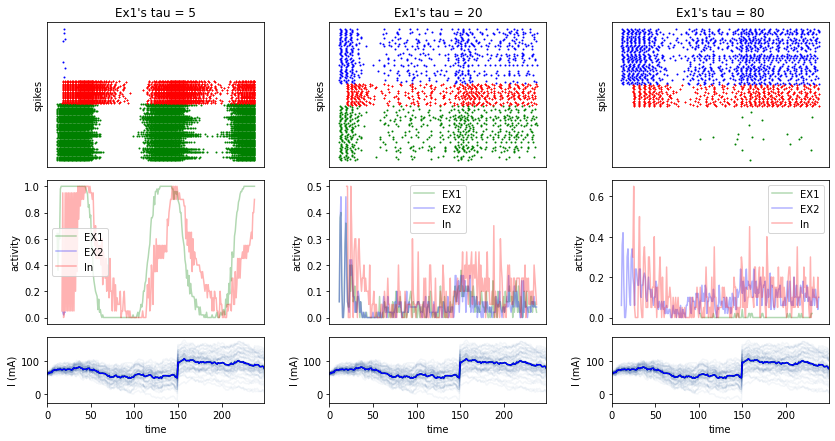

In [22]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)

new_Ex1 = LIFPopulation((50,), tau=5, is_excitatory=True, dt=dt)
simulate(new_Ex1, '1', "Ex1's tau = 5")

new_Ex1 = LIFPopulation((50,), tau=20, is_excitatory=True, dt=dt)
simulate(new_Ex1, '2', "Ex1's tau = 20")

new_Ex1 = LIFPopulation((50,), tau=80, is_excitatory=True, dt=dt)
simulate(new_Ex1, '3', "Ex1's tau = 80")

p.show()

<div dir='rtl'>
<br/>
همانطور که می‌بینیم، با کاهش ثابت زمانی و افزایش حساسیت جمعیت سبز، این جمعیت در امر واکنش نشان دادن به ورودی سریع‌تر عمل کرده و عامل بازدارنده را به سوی جمعیت آبی سرازیر می‌کند و به این ترتیب، بازی را برنده می‌شود.
</div>

<a id='9'></a>
<div dir='rtl'>
    <h2>9. اندازه جمعیت بازدارنده</h2>
</div>

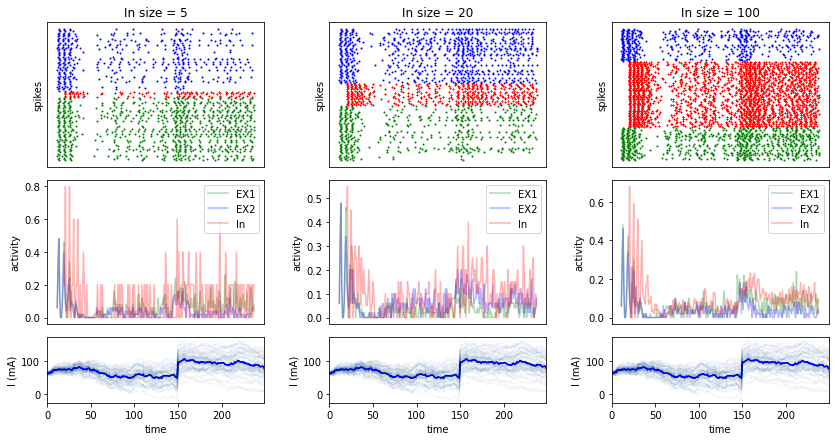

In [23]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)

def simulate(pop,postfix,name):
    conn_Ex1,conn_Ex2,conn_Ex1_In,conn_Ex2_In,conn_In_Ex1,conn_In_Ex2 = default_conn(Ex1,Ex2,pop)
    return dm_simulate(p, {
        'Ex1':Ex1,
        'Ex2':Ex2,
        'In':pop,
        'conn_Ex1': conn_Ex1,
        'conn_Ex2': conn_Ex2,
        'conn_Ex1_In': conn_Ex1_In,
        'conn_Ex2_In': conn_Ex2_In,
        'conn_In_Ex1': conn_In_Ex1,
        'conn_In_Ex2': conn_In_Ex2,
    }, I1, I1, postfix=postfix, name=name)

new_In = LIFPopulation((5,), is_excitatory=False, dt=dt)
simulate(new_In, '1', 'In size = 5')

new_In = LIFPopulation((20,), is_excitatory=False, dt=dt)
simulate(new_In, '2', 'In size = 20')

new_In = LIFPopulation((100,), is_excitatory=False, dt=dt)
simulate(new_In, '3', 'In size = 100')

p.show()

<div dir='rtl'>
<br/>
- وقتی تعداد نورون‌های بازدارنده بسیار کم باشد، این نورون‌ها نمی‌توانند تأثیر کل یک جمعیت دیگر را مورد پوشش قرار دهند و به این ترتیب، بازدارندگی کمی از خود نشان می‌دهند. به همین دلیل در دو نمودار اول مشاهده می‌کنیم که با افزایش این تعداد، بازدارندگی زیاد شده و دو جمعیت تحریکی کم فعالیت می‌شوند.
<br/>
- می‌بینیم که زمانی که تعداد نورون‌های مهاری بسیار زیاد می‌شود، دوباره از قدرت کاهندگی آن‌ها کم می‌شود.
    دلیل آن است که با افزایش تعداد نورون‌ها، به دلیل نرمال‌سازی تأثیرات توسط وزن اتصالات، تأثیر هر نورون کم می‌شود اما دقت کنید که تعداد نورون‌های مهاری از نورون‌های هر جمعیت تحریکی بیشتر شده و به این صورت، جمعیت مهاری نمی‌تواند از تمام نیروی خود برای مهار یک جمعیت دیگر استفاده کند و بخش زیادی از آن را از دست می‌دهد.
</div>

<a id='10'></a>
<div dir='rtl'>
    <h2>10. ثابت زمانی ( 𝑡𝑎𝑢 ) جمعیت بازدارنده</h2>
</div>

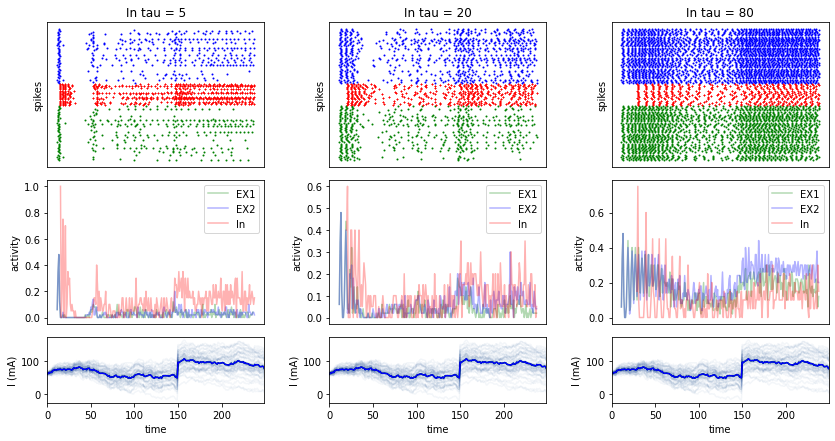

In [25]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2','s3'],
    ['s1','s2','s3'],
    ['a1','a2','a3'],
    ['a1','a2','a3'],
    ['i1','i2','i3'],
], wspace=0.3)

def simulate(pop,postfix,name):
    return dm_simulate(p, {
        'Ex1':Ex1,
        'Ex2':Ex2,
        'In':pop,
        'conn_Ex1': conn_Ex1,
        'conn_Ex2': conn_Ex2,
        'conn_Ex1_In': conn_Ex1_In,
        'conn_Ex2_In': conn_Ex2_In,
        'conn_In_Ex1': conn_In_Ex1,
        'conn_In_Ex2': conn_In_Ex2,
    }, I1, I1, postfix=postfix, name=name)

new_In = LIFPopulation((20,), tau=5, is_excitatory=False, dt=dt)
simulate(new_In, '1', 'In tau = 5')

new_In = LIFPopulation((20,), tau=20, is_excitatory=False, dt=dt)
simulate(new_In, '2', 'In tau = 20')

new_In = LIFPopulation((20,), tau=80, is_excitatory=False, dt=dt)
simulate(new_In, '3', 'In tau = 80')

p.show()

<div dir='rtl'>
<br/>
مشاهده می‌کنیم که با افزایش ثابت زمانی و در نتیجه افزایش لختی جمعیت نورونی مهاری، این جمعیت قدرت خود در مهار دو جمعیت دیگر را از دست داده و دو جمعیت رشد می‌کنند. این مسئله مورد انتظار است چون لختی زیاد باعث کاهش سرعت اسپایک زدن می‌شود.
</div>

<a id='11'></a>
<div dir='rtl'>
    <h2>11. شبکه «کاملا» متقارن</h2>
<br/>
    در مطالب تدریسی بیان شد که اتصالات به دو جمعیت تحریکی باید دقیقا یکسان باشد. ما در این تمرین این اتصالات را با پارامتر‌های یکسان بازتولید کردیم که الزاما به معنای شباهت صددرصد نیست. در این بخش این دو حالت را در کنار هم مقایسه می‌کنیم.
</div>

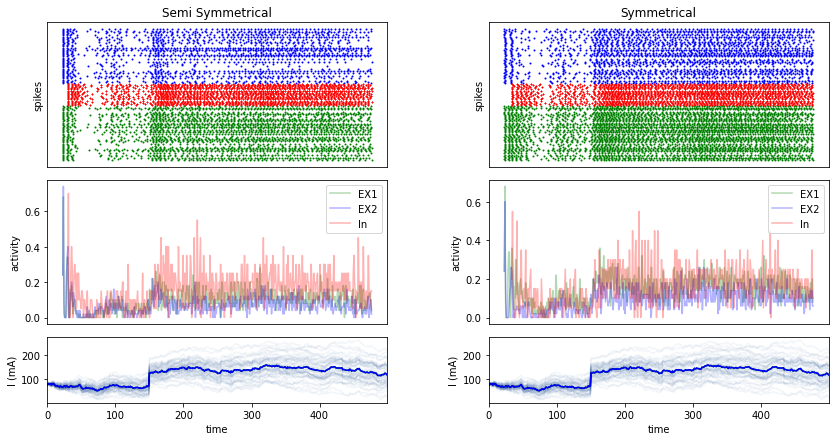

In [27]:
plt.figure(figsize=(14,7))
p = Plotter([
    ['s1','s2'],
    ['s1','s2'],
    ['a1','a2'],
    ['a1','a2'],
    ['i1','i2'],
], wspace=0.3)

I1 = generate_function(time*2, shape=(50,),
           shift={0: 75, 150: 50},
           noise=1,
           population_noise=1)
def simulate(conn,conn_ExIn,conn_InEx,postfix,name):
    return dm_simulate(p, {
        'Ex1':Ex1,
        'Ex2':Ex2,
        'In':In,
        'conn_Ex1': conn_Ex1,
        'conn_Ex2': conn,
        'conn_Ex1_In': conn_Ex1_In,
        'conn_Ex2_In': conn_ExIn,
        'conn_In_Ex1': conn_In_Ex1,
        'conn_In_Ex2': conn_InEx,
    }, I1, I1, postfix=postfix, name=name, time=2*time)

simulate(conn_Ex2,conn_Ex2_In,conn_In_Ex2, '1', 'Semi Symmetrical')


conn = SimpleConnection(pre=Ex2, post=Ex2, dt=dt,
                        connectivity=conn_Ex1.copy_connectivity,
                        w=conn_Ex1.copy_w)
conn_ExIn = SimpleConnection(pre=Ex2, post=In, dt=dt,
                        connectivity=conn_Ex1_In.copy_connectivity,
                        w=conn_Ex1_In.copy_w)
conn_InEx = SimpleConnection(pre=In, post=Ex2, dt=dt,
                        connectivity=conn_In_Ex1.copy_connectivity,
                        w=conn_In_Ex1.copy_w)
simulate(conn,conn_ExIn,conn_InEx, '2', 'Symmetrical')


p.show()

<div dir='rtl'>
<br/>
مشاهده می‌شود که در حالت کاملا متقارن، رفتار دو جمعیت کاملا بر هم منطبق است و رقابت به صورت پایاپای ادامه می‌یابد. حال آنکه در حالت نیمه متقارن، کمی اختلاف در الگوی اسپایکی مشاهده می‌شود و همچنین می‌توان دید که جمعیت سبز رو به پیروزیست (هرچند خیلی آهسته ولی اختلاف در حال رشد است). 
</div>